# Chapter 2: End-to-End Machine Learning Project

## Preliminaries

In [40]:
import sys

assert sys.version_info >= (3, 7)

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

## Get the Data

Welcome to Machine Learning Housing Corp.! Your task is to predict median house values in Californian districts, given a number of features from these districts.

In [41]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if check_if_data_was_loaded():
        df = pd.read_csv(Path("datasets/housing/housing.csv"))
        if tarball_path.is_file():
            tarball_path.unlink()
        return df
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets", filter=lambda x: x.name.endswith(".csv"))
        tarball_path.unlink()

    return pd.read_csv(Path("datasets/housing/housing.csv"))

def check_if_data_was_loaded():
    data_path = Path("datasets/housing/housing.csv")
    if not data_path.is_file():
        return False
    print("Data already loaded at datasets/housing/housing.csv")
    return True

housing = load_housing_data()

Data already loaded at datasets/housing/housing.csv


## Explore the data

In [42]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [43]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [44]:
print(housing["total_bedrooms"].count()) # automatically counts non-null values for total_bedrooms
print(housing["total_bedrooms"].isnull().sum()) # counts null values for total_bedrooms

20433
207


In [45]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [46]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


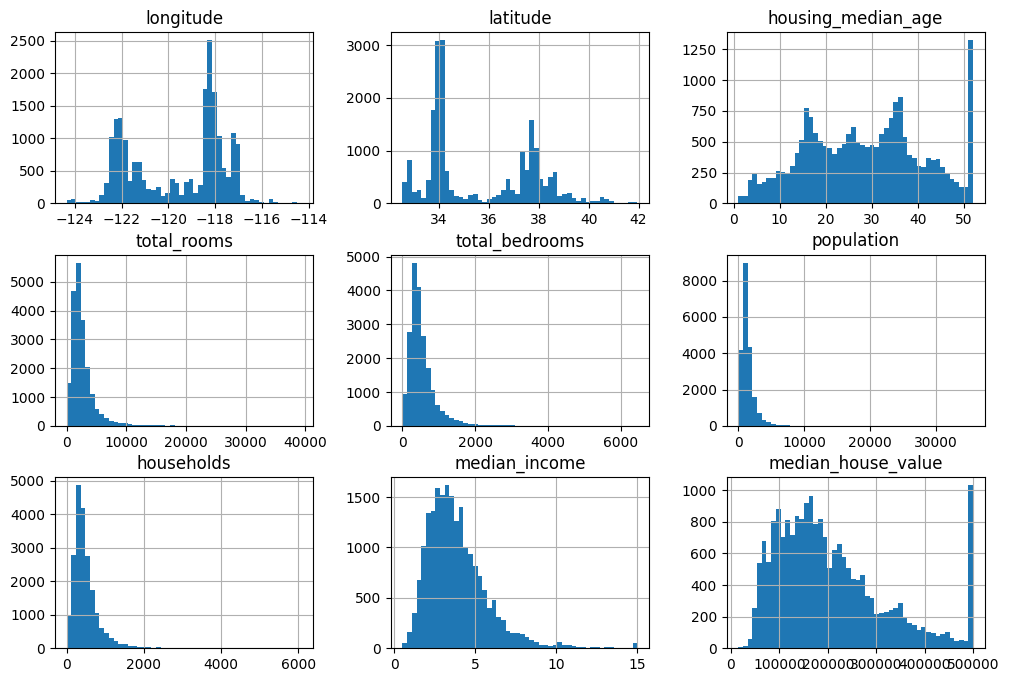

In [47]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(12,8))
plt.show()

## Create a Test Set

In [48]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    len_data = len(data)
    shuffled_indices = np.random.permutation(len_data) # 
    test_set_size = int(len_data * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [49]:
train_set, test_set = shuffle_and_split_data(housing, 0.2)

In [50]:
len(train_set), len(test_set)

(16512, 4128)

In [51]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [52]:
housing_with_id = housing.reset_index()
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_data_with_id_hash(housing_with_id, 0.2, "id")

Easiest way to split your training data is to use existing Scikit-Learn functions

In [54]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42) # random_state is the seed for the random number generator, chosen because it's the answer to the ultimate question of life, the universe, and everything


### Create income categories for better representation in our training dataset

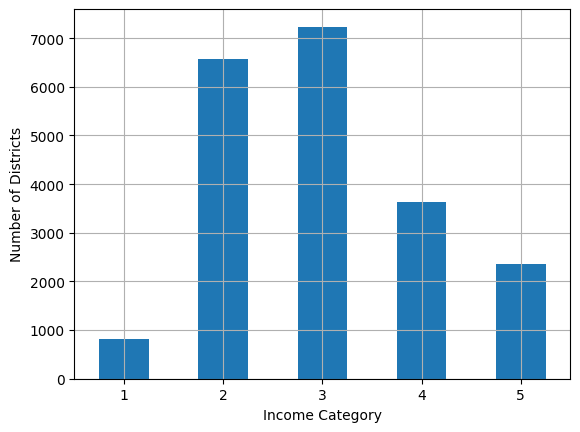

In [55]:
housing["income_cat"] = pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income Category")
plt.ylabel("Number of Districts")
plt.show()

In [56]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.iloc[train_index]
    strat_test_set_n = housing.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [57]:
strat_train_set, strat_test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"],random_state=42)

In [58]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)*100

income_cat
3    35.053295
2    31.879845
4    17.635659
5    11.434109
1     3.997093
Name: count, dtype: float64

In [59]:
for _strat in (strat_train_set, strat_test_set):
    _strat.drop("income_cat", axis=1, inplace=True)

## Explore and Visualze the Data to Gain Insights

In [60]:
housing = strat_train_set.copy()

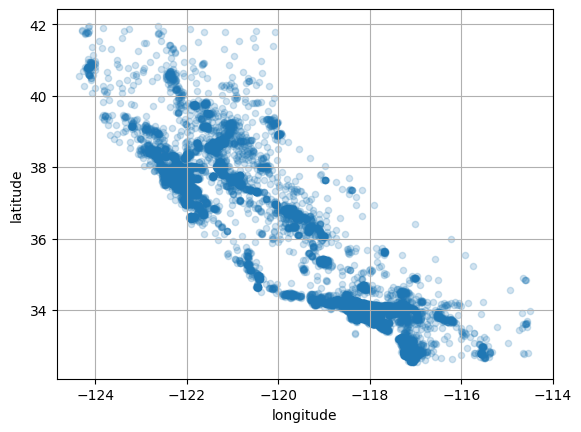

In [61]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)
plt.show()

<Axes: xlabel='population_cat'>

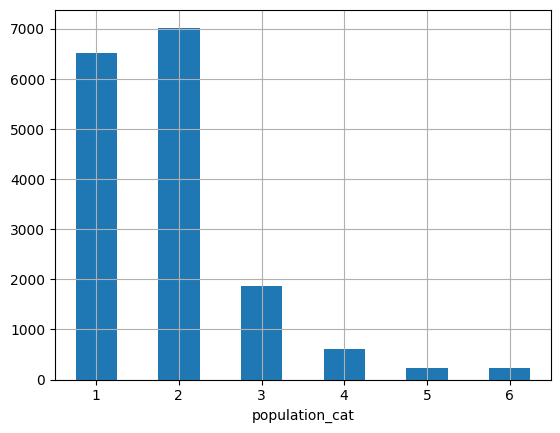

In [62]:
housing["population_cat"] = pd.cut(housing["population"], bins=[0., 1000, 2000, 3000, 4000, 5000, np.inf], labels=[1, 2, 3, 4, 5, 6])
housing["population_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)

In [63]:
housing = strat_train_set.copy()

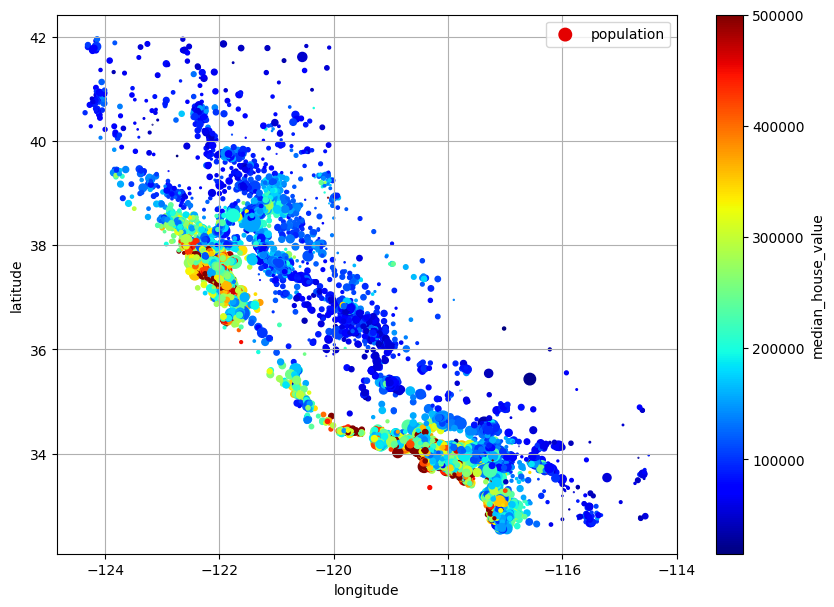

In [64]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, 
             s=housing["population"]/100, label="population",
             c="median_house_value", cmap="jet", colorbar=True, 
             legend="True", sharex=False, figsize=(10,7))
plt.show()

In [65]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   median_house_value  16512 non-null  float64
 9   ocean_proximity     16512 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.4+ MB


In [66]:
housing_sans_ocean_prox = housing.drop("ocean_proximity", axis=1)
corr_matrix = housing_sans_ocean_prox.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

array([[<Axes: xlabel='median_house_value', ylabel='median_house_value'>,
        <Axes: xlabel='median_income', ylabel='median_house_value'>],
       [<Axes: xlabel='median_house_value', ylabel='median_income'>,
        <Axes: xlabel='median_income', ylabel='median_income'>]],
      dtype=object)

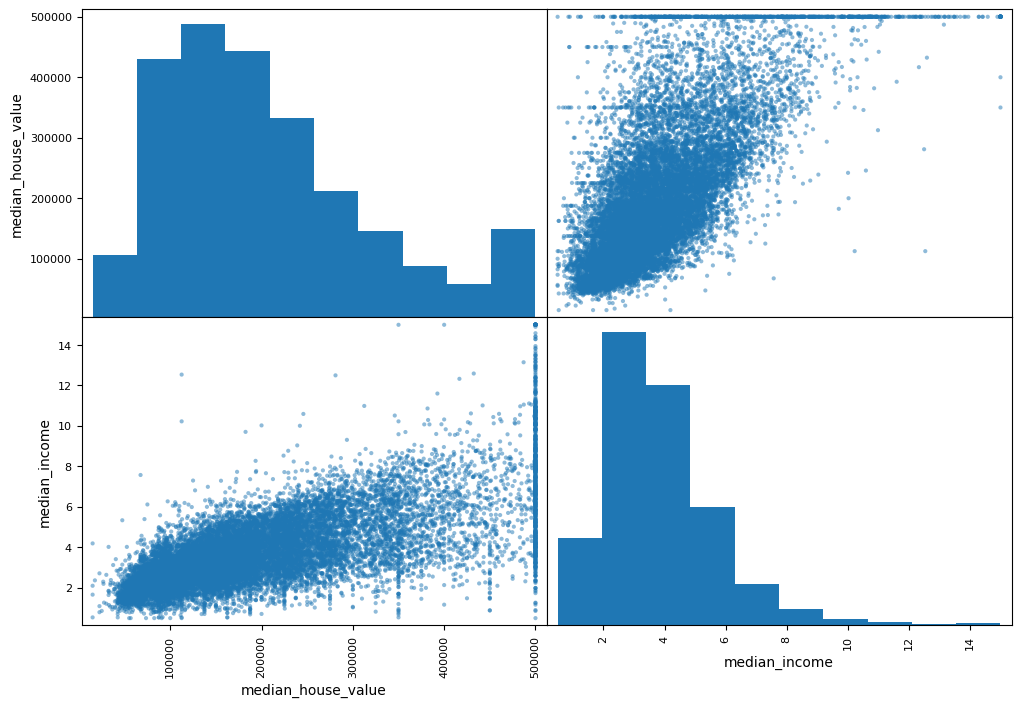

In [67]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income"]
scatter_matrix(housing[attributes], figsize=(12,8))


In [68]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [69]:
housing_sans_ocean_prox = housing.drop("ocean_proximity", axis=1)
corr_matrix = housing_sans_ocean_prox.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

## Prepare the Data for Machine Learning Algorithms

In [70]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [71]:
from sklearn.impute import SimpleImputer
housing_num = housing.select_dtypes(include=[np.number])
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [72]:
# Convert ocean_proximity to numbers
from sklearn.preprocessing import OneHotEncoder

housing_cat = housing[["ocean_proximity"]]
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)


In [73]:
housing_cat_1hot.toarray()

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

## Prepare the Data for ML Algorithms

In [ ]:
# Remove labels from training set and create a labels set
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy() # labels for training set

In [75]:
# The total_bedrooms attribute has some missing values, so we need to fill them in using the SimpleImputer class from sklearn
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

# This can only be done on numerical attributes, so we need to drop the ocean_proximity attribute
housing_num = housing.drop("ocean_proximity", axis=1)
# Fit the imputer instance to the training data
imputer.fit(housing_num)

# It is possible that other attributes may miss data when the system goes live, so we need to apply the imputer to all numerical attributes
X = imputer.transform(housing_num)

# Recover the column names and indices
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

The ocean proximity attribute is a categorical attribute: there are a limited number of different strings representing categories. ML algorithms prefer working with numbers rather than text, so we can convert these categories to numbers. 

In [ ]:
from sklearn.preprocessing import OneHotEncoder

housing_cat = housing[["ocean_proximity"]]
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)